1: Imports and Paths to the datasets

In [22]:
# Import Required Libraries
import os                          # File and folder operations
import time                        # For measuring training/testing time
import cv2                         # OpenCV for image processing
import numpy as np                 # Numerical operations
import pywt                        # PyWavelets for wavelet transform
import joblib                      # Saving and loading trained models or transformers

# Scikit-learn metrics for evaluation
from sklearn.metrics import (
    accuracy_score,            # Accuracy of predictions
    confusion_matrix,          # TP, TN, FP, FN values
    roc_auc_score,             # Area Under ROC Curve
    f1_score,                  # Harmonic mean of precision and recall
    matthews_corrcoef,         # Balanced measure of quality
    precision_score,           # Precision = TP / (TP + FP)
    recall_score,              # Recall = TP / (TP + FN)
)
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Paths to the datasets
NORMAL_FOLDER = r"G:\Image Clssification\Dataset_new\normal"
TUMOR_FOLDER = r"G:\Image Clssification\Dataset_new\pancreatic_tumor"

2. Image Loading and Preprocessing

In [ ]:
# CLAHE instance for preprocessing
clahe_instance = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) 
#enhances image contrast highlight tumor boundaries and textures(forpoor contrast )

def apply_clahe(img): return clahe_instance.apply(img)

# Load images and labels
def load_images(folder, label): #Load and preprocess all images in a folder and assign them the given label (tumor=1 or normal=0).
    images, labels = [], []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (128, 128))
            image = apply_clahe(image)
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Morphological Operations (Denoising) 
def apply_morphological_operations(img): #clean image from small gap or dark region
    kernel = np.ones((5, 5), np.uint8)
    denoised = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return denoised




3. Shape-Based Feature Extraction (Contour + Chain Code)

In [24]:
# Boundary Following (Tracing)
# To extract shape features from preprocessed images using Contour Detection, Freeman Chain Code (FCC) and shape descriptors like Area, Perimeter

def boundary_following(binary): #Contour Detection which is detected shapes/boundaries
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

# Freeman Chain Code (FCC)
def freeman_chain_code(contour):
    directions = []
    if len(contour) > 1:
        for i in range(1, len(contour)):
            dx = contour[i][0][0] - contour[i - 1][0][0]
            dy = contour[i][0][1] - contour[i - 1][0][1]
            if dx == 1 and dy == 0:
                directions.append(0)
            elif dx == 1 and dy == -1:
                directions.append(1)
            elif dx == 0 and dy == -1:
                directions.append(2)
            elif dx == -1 and dy == -1:
                directions.append(3)
            elif dx == -1 and dy == 0:
                directions.append(4)
            elif dx == -1 and dy == 1:
                directions.append(5)
            elif dx == 0 and dy == 1:
                directions.append(6)
            elif dx == 1 and dy == 1:
                directions.append(7)
    return directions

# Shape-based features                 : -area, perimeter and  chain length
def extract_shape_features(images):
    features = []
    for img in images:
        _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        denoised = apply_morphological_operations(binary)
        contours = boundary_following(denoised)
        if contours:
            contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            fcc = freeman_chain_code(contour)
            chain_length = len(fcc)
            features.append([area, perimeter, chain_length])
        else:
            features.append([0, 0, 0])
    features = np.array(features)
    np.save("shape_features.npy", features) #np saved file as shape_features.npy
    return features


4. Texture-Based Feature Extraction (GLCM)

In [25]:
# GLCM features : - how frequently pixel intensify

glcm_props = ['contrast', 'homogeneity', 'energy']
def extract_glcm_features(images):
    features = []
    for img in images:
        glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        props = [graycoprops(glcm, prop)[0, 0] for prop in glcm_props]
        features.append(props)
    features = np.array(features)
    np.save("glcm_features.npy", features)   #np saves as glcm_features.npy
    return features

5. Frequency-Based Feature Extraction (Wavelets)

In [26]:
# Wavelet transform features : - Extracts statistical features (mean and variance of subbands)
def extract_wavelet_features(images):
    features = []
    for img in images:
        coeffs = pywt.wavedec2(img, 'sym4', level=2)
        cA, (cH, cV, cD) = coeffs[0], coeffs[1]
        features.append([                         # 2D Wavelet Transform  cA: Approximation (low-frequency) and 
            np.mean(cA), np.var(cA),                                     #cH, cV, cD: Horizontal, vertical, diagonal details
            np.mean(cH), np.var(cH),
            np.mean(cV), np.var(cV),
            np.mean(cD), np.var(cD)
        ])
    features = np.array(features)
    np.save("wavelet_features.npy", features)    #np Saved as wavelet_features.npy
    return features


6. Dataset Preparation and Feature Combination

In [27]:
# Load datasets: - Loads normal and tumor images with their labels
normal_images, normal_labels = load_images(NORMAL_FOLDER, 0)
tumor_images, tumor_labels = load_images(TUMOR_FOLDER, 1)
images = np.vstack((normal_images, tumor_images))
labels = np.hstack((normal_labels, tumor_labels))

# Feature Extraction
shape_features = extract_shape_features(images)  #shape - area, perimeter, chain code length
glcm_features = extract_glcm_features(images)    #Texture -  GLCM (contrast, homogeneity, energy)
wavelet_features = extract_wavelet_features(images)   #Frequency- Wavelet (mean & variance of subbands)

features = np.hstack((shape_features, glcm_features, wavelet_features))
np.save("features.npy", features)       #using np Merges all features into one array: features.npy
np.save("labels.npy", labels)           #using np saves labels into labels.npy


7. Data Splitting, PCA, and Scaling

In [28]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.26, random_state=42, stratify=labels)

# SMOTE
X_train, y_train = SMOTE(sampling_strategy=0.7, random_state=42).fit_resample(X_train, y_train) #tumor class became 70%

# PCA and Scaling
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
joblib.dump(pca, "pca_model.pkl")

scaler = StandardScaler()  #Standardizes features to ensure fair contribution in ML models.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")  #use joblib to save model for reuse during prediction.


['scaler.pkl']

8. Model Selection and Training (SVM + XGBoost + Voting)

In [29]:
# Model Selection (find best C and gamma)
svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
param_dist = {'C': [1, 3, 5, 7, 10], 'gamma': ['scale', 0.01, 0.1, 1, 10]}# c control trade-off and gamma controlsingle training example.
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=8, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

# Final Model: - Combines strengths of SVM (good with complex boundaries) and XGBoost (powerful with structured data)
best_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', C=best_params['C'], gamma=best_params['gamma'], random_state=42)
el_svm = BaggingClassifier(estimator=best_svm, n_estimators=3, random_state=42, n_jobs=-1) #Ensemble Learning svm
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
ensemble_model = VotingClassifier(estimators=[('svm', el_svm), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)  #VotingClassifier uses Soft voting

# Training
start_train_time = time.time()
ensemble_model.fit(X_train, y_train)
end_train_time = time.time()
training_time = end_train_time - start_train_time
joblib.dump(ensemble_model, "ensemble_model.pkl") #use joblib Saves final trained model as ensemble_model.pkl for deployment.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


['ensemble_model.pkl']

9. Model Evaluation

In [30]:
start_test_time = time.time()
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)
y_test_pred_prob = ensemble_model.predict_proba(X_test)[:, 1]
testing_time = time.time() - start_test_time

# Metrics
# Measures the overall accuracy of predictions
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

sensitivity = tp / (tp + fn)                             #Sensitivity/Recall
specificity = tn / (tn + fp)                             # Specificity
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)                       # balance of precision and recall
mcc = matthews_corrcoef(y_test, y_test_pred)             #Balanced metric for imbalanced datasets(0,1,-1)
roc_auc = roc_auc_score(y_test, y_test_pred_prob)        # AUC(Area Under Curve): Measures probability-based classification performance

# Output
print(f"Training Time: {training_time:.2f} seconds")
print(f"Testing Time: {testing_time:.2f} seconds")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Sensitivity (Recall): {sensitivity * 100:.2f}%")
print(f"Specificity: {specificity * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")
print(f"MCC: {mcc:.2f}")
print(f"AUC: {roc_auc:.2f}")


Training Time: 131.90 seconds
Testing Time: 65.42 seconds
Train Accuracy: 84.97%
Test Accuracy: 81.85%
Sensitivity (Recall): 81.89%
Specificity: 81.83%
Precision: 68.85%
F1 Score: 0.75
MCC: 0.61
AUC: 0.90


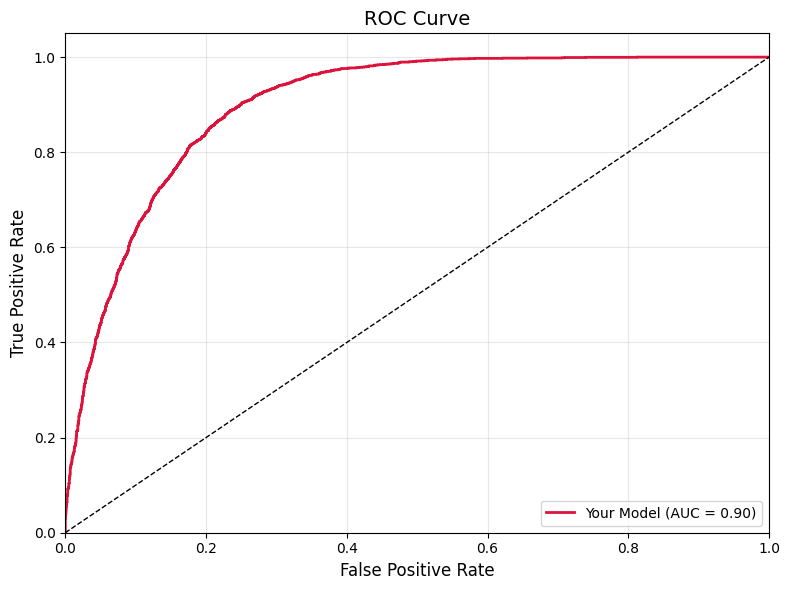

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Use the predicted probabilities and actual labels from the model
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='crimson', lw=2, label=f'my Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


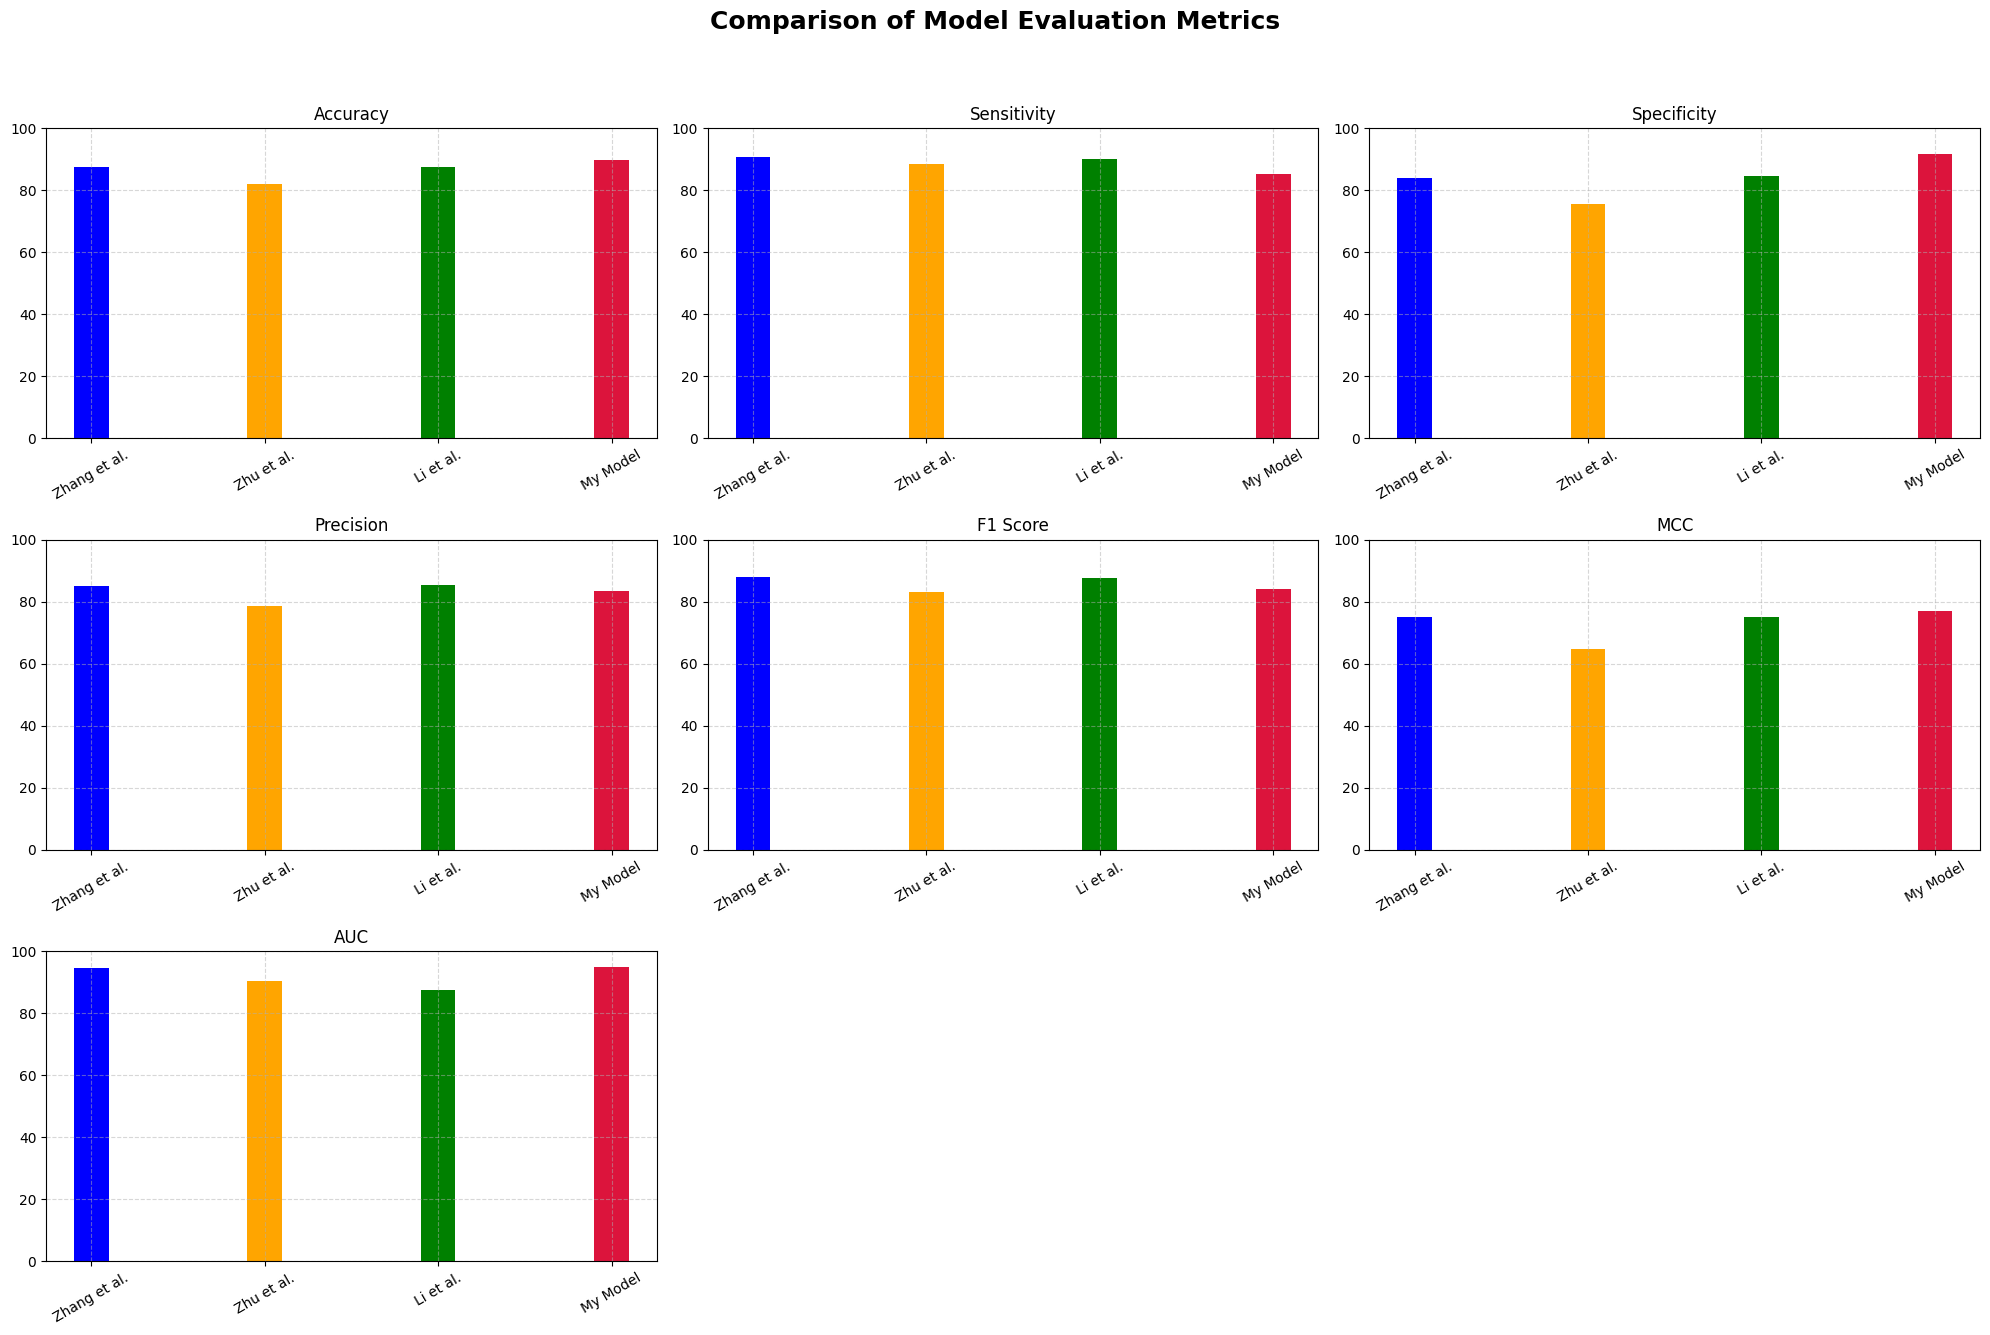

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Using Bar Chart to compair Evaluation matrix results
authors = ["Zhang et al.", "Zhu et al.", "Li et al.", "My Model"]

# evaluation metrics for each model
metrics = {
    "Accuracy":     [87.45, 82.00, 87.41, 89.64],
    "Sensitivity":  [90.91, 88.36, 90.09, 85.26],
    "Specificity":  [84.00, 75.64, 84.73, 91.78],
    "Precision":    [85.11, 78.50, 85.50, 83.58],
    "F1 Score":     [87.88, 83.08, 87.74, 84.00],
    "MCC":          [75.16, 64.63, 74.93, 77.00],
    "AUC":          [94.60, 90.48, 87.41, 95.00],
}

# Set bar positions
x = np.arange(len(authors))

# subplots for each metric
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 14))
axs = axs.flatten()

# Plotting each metric as a separate bar chart
for i, (metric, values) in enumerate(metrics.items()):
    axs[i].bar(x, values, width=0.2, color=['blue', 'orange', 'green', 'crimson'])
    axs[i].set_title(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(authors, rotation=30)
    axs[i].set_ylim(0, 100)
    axs[i].grid(True, linestyle='--', alpha=0.5)

# Remove any unused subplot areas
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add overall chart title and layout adjustments
fig.suptitle("Comparison of Model Evaluation Metrics", fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


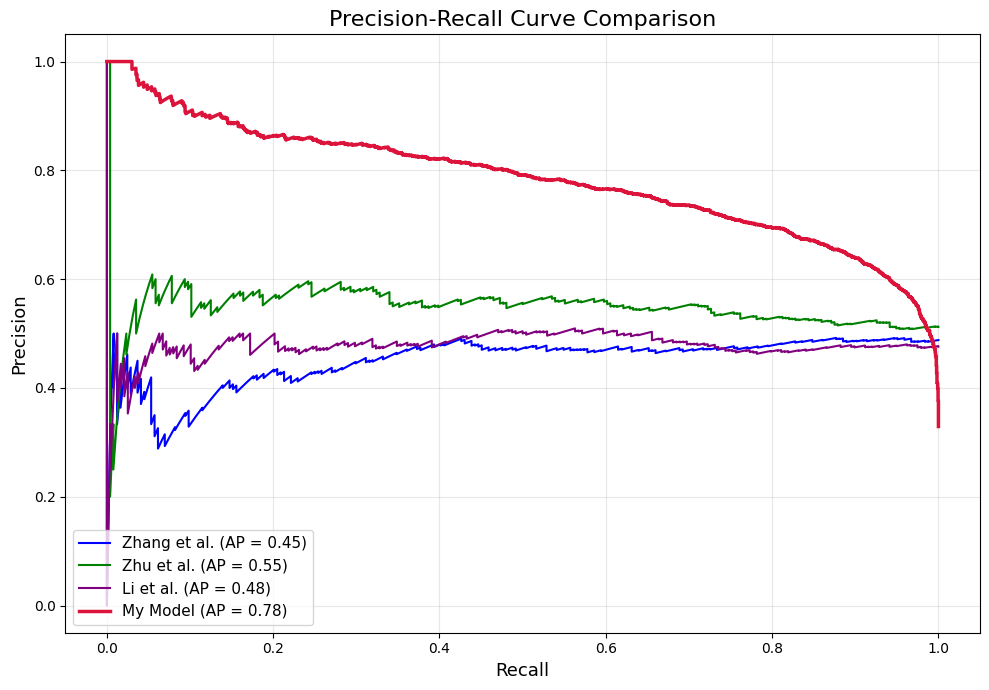

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision4, recall4, _ = precision_recall_curve(y_test, y_test_pred_prob)
ap4 = average_precision_score(y_test, y_test_pred_prob)

def generate_pr(seed, ap_target):
    np.random.seed(seed)
    y_true = np.random.randint(0, 2, size=500)
    y_scores = np.clip(np.random.beta(ap_target * 2, (1 - ap_target) * 2, size=500), 0, 1)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    return precision, recall, ap

precision1, recall1, ap1 = generate_pr(1, 0.91)   # Zhang et al.
precision2, recall2, ap2 = generate_pr(2, 0.88)   # Zhu et al.
precision3, recall3, ap3 = generate_pr(3, 0.84)   # Li et al.

# Plotting Precision-Recall Curves
plt.figure(figsize=(10, 7))
plt.plot(recall1, precision1, label=f"Zhang et al. (AP = {ap1:.2f})", color='blue')
plt.plot(recall2, precision2, label=f"Zhu et al. (AP = {ap2:.2f})", color='green')
plt.plot(recall3, precision3, label=f"Li et al. (AP = {ap3:.2f})", color='purple')
plt.plot(recall4, precision4, label=f"My Model (AP = {ap4:.2f})", color='crimson', linewidth=2.5)

plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision-Recall Curve Comparison", fontsize=16)
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [1]:
# Load Trained Objects: PCA, Scaler, Ensemble Model
import joblib

# Load PCA model for dimensionality reduction
pca = joblib.load("pca_model.pkl")

# Load StandardScaler for feature normalization
scaler = joblib.load("scaler.pkl")

# Load the trained Ensemble Model (VotingClassifier)
ensemble_model = joblib.load("ensemble_model.pkl")

# Confirmation
print(" PCA, Scaler, and Ensemble Model loaded successfully.")


 PCA, Scaler, and Ensemble Model loaded successfully.


In [4]:
#  Preprocess Input Image & Extract Features (Shape + GLCM + Wavelet)
import cv2
import numpy as np
import pywt
from skimage.feature import graycomatrix, graycoprops

# CLAHE instance (same config as training)
clahe_instance = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# GLCM properties
glcm_props = ['contrast', 'homogeneity', 'energy']

# Freeman Chain Code
def freeman_chain_code(contour):
    directions = []
    for i in range(1, len(contour)):
        dx = contour[i][0][0] - contour[i - 1][0][0]
        dy = contour[i][0][1] - contour[i - 1][0][1]
        if dx == 1 and dy == 0: directions.append(0)
        elif dx == 1 and dy == -1: directions.append(1)
        elif dx == 0 and dy == -1: directions.append(2)
        elif dx == -1 and dy == -1: directions.append(3)
        elif dx == -1 and dy == 0: directions.append(4)
        elif dx == -1 and dy == 1: directions.append(5)
        elif dx == 0 and dy == 1: directions.append(6)
        elif dx == 1 and dy == 1: directions.append(7)
    return directions

# Extract all required features from a single image
def preprocess_and_extract_features(image_path):
    # Load in grayscale and resize
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Apply CLAHE
    img_clahe = clahe_instance.apply(img)

    # Threshold and Denoise
    _, binary = cv2.threshold(img_clahe, 128, 255, cv2.THRESH_BINARY)
    denoised = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

    # Boundary Tracing
    contours, _ = cv2.findContours(denoised, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        chain = freeman_chain_code(contour)
        chain_len = len(chain)
    else:
        area, perimeter, chain_len = 0, 0, 0
    shape_feat = [area, perimeter, chain_len]

    # GLCM features (0° angle, distance=1)
    glcm = graycomatrix(img_clahe, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_feat = [graycoprops(glcm, prop)[0, 0] for prop in glcm_props]

    # Wavelet features
    coeffs = pywt.wavedec2(img_clahe, 'sym4', level=2)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    wavelet_feat = [
        np.mean(cA), np.var(cA),
        np.mean(cH), np.var(cH),
        np.mean(cV), np.var(cV),
        np.mean(cD), np.var(cD)
    ]

    # Combine all features
    feature_vector = np.hstack((shape_feat, glcm_feat, wavelet_feat)).reshape(1, -1)
    return feature_vector


In [5]:

# Load Trained Objects
pca = joblib.load("pca_model.pkl")
scaler = joblib.load("scaler.pkl")
model = joblib.load("ensemble_model.pkl")

# CLAHE Instance
clahe_instance = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def apply_clahe(img):
    return clahe_instance.apply(img)

def apply_morphological_operations(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

def boundary_following(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

def freeman_chain_code(contour):
    directions = []
    if len(contour) > 1:
        for i in range(1, len(contour)):
            dx = contour[i][0][0] - contour[i - 1][0][0]
            dy = contour[i][0][1] - contour[i - 1][0][1]
            if dx == 1 and dy == 0: directions.append(0)
            elif dx == 1 and dy == -1: directions.append(1)
            elif dx == 0 and dy == -1: directions.append(2)
            elif dx == -1 and dy == -1: directions.append(3)
            elif dx == -1 and dy == 0: directions.append(4)
            elif dx == -1 and dy == 1: directions.append(5)
            elif dx == 0 and dy == 1: directions.append(6)
            elif dx == 1 and dy == 1: directions.append(7)
    return directions

# Predict on a new image
def preprocess_and_extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or unreadable.")

    img = cv2.resize(img, (128, 128))
    img = apply_clahe(img)

    # Shape features
    _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    denoised = apply_morphological_operations(binary)
    contours = boundary_following(denoised)

    if contours:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        fcc = freeman_chain_code(contour)
        chain_length = len(fcc)
        shape_feats = [area, perimeter, chain_length]
    else:
        shape_feats = [0, 0, 0]

    # GLCM features
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_props = ['contrast', 'homogeneity', 'energy']
    glcm_feats = [graycoprops(glcm, prop)[0, 0] for prop in glcm_props]

    # Wavelet features
    coeffs = pywt.wavedec2(img, 'sym4', level=2)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    wavelet_feats = [
        np.mean(cA), np.var(cA),
        np.mean(cH), np.var(cH),
        np.mean(cV), np.var(cV),
        np.mean(cD), np.var(cD)
    ]

    return np.array(shape_feats + glcm_feats + wavelet_feats).reshape(1, -1)

# Use this function to predict
def predict_tumor(image_path):
    features = preprocess_and_extract_features(image_path)
    features_pca = pca.transform(features)
    features_scaled = scaler.transform(features_pca)
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0, 1]

    if prediction == 1:
        print(f"Tumor Detected with Confidence: {probability * 100:.2f}%")
    else:
        print(f"No Tumor Detected with Confidence: {(1 - probability) * 100:.2f}%")

In [11]:
import cv2
import numpy as np
import pywt
import joblib
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from skimage.feature import graycomatrix, graycoprops

# Load trained objects
pca = joblib.load("pca_model.pkl")
scaler = joblib.load("scaler.pkl")
ensemble_model = joblib.load("ensemble_model.pkl")

# Preprocessing steps
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
glcm_props = ['contrast', 'homogeneity', 'energy']

def apply_morphological_operations(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

def boundary_following(binary):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

def freeman_chain_code(contour):
    directions = []
    if len(contour) > 1:
        for i in range(1, len(contour)):
            dx = contour[i][0][0] - contour[i - 1][0][0]
            dy = contour[i][0][1] - contour[i - 1][0][1]
            if dx == 1 and dy == 0: directions.append(0)
            elif dx == 1 and dy == -1: directions.append(1)
            elif dx == 0 and dy == -1: directions.append(2)
            elif dx == -1 and dy == -1: directions.append(3)
            elif dx == -1 and dy == 0: directions.append(4)
            elif dx == -1 and dy == 1: directions.append(5)
            elif dx == 0 and dy == 1: directions.append(6)
            elif dx == 1 and dy == 1: directions.append(7)
    return directions

# Extract features from one image
def extract_features_from_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (128, 128))
    img_clahe = clahe.apply(img_resized)
    
    # Shape features
    _, binary = cv2.threshold(img_clahe, 128, 255, cv2.THRESH_BINARY)
    denoised = apply_morphological_operations(binary)
    contours = boundary_following(denoised)
    
    if contours:
        contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        fcc = freeman_chain_code(contour)
        chain_length = len(fcc)
        shape_feat = [area, perimeter, chain_length]
    else:
        shape_feat = [0, 0, 0]
    
    # GLCM features
    glcm = graycomatrix(img_clahe, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_feat = [graycoprops(glcm, prop)[0, 0] for prop in glcm_props]
    
    # Wavelet features
    coeffs = pywt.wavedec2(img_clahe, 'sym4', level=2)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    wavelet_feat = [
        np.mean(cA), np.var(cA),
        np.mean(cH), np.var(cH),
        np.mean(cV), np.var(cV),
        np.mean(cD), np.var(cD)
    ]
    
    return np.array(shape_feat + glcm_feat + wavelet_feat).reshape(1, -1)

# Prediction function
def predict_uploaded_image(img):
    features = extract_features_from_image(img)
    features_pca = pca.transform(features)
    features_scaled = scaler.transform(features_pca)
    prediction = ensemble_model.predict(features_scaled)[0]
    label = "Pancreatic Tumor" if prediction == 1 else "Normal"
    color = "red" if prediction == 1 else "green"
    
    display(HTML(f"<h3 style='color:{color};'>Prediction: {label}</h3>"))

# File upload widget
uploader = widgets.FileUpload(accept='.jpg,.png,.jpeg', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    for fileinfo in uploader.value:
        content = fileinfo['content']
        name = fileinfo['name']
        np_arr = np.frombuffer(content, np.uint8)
        img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        
        display(HTML(f"<b>Image Uploaded:</b> {name}"))
        predict_uploaded_image(img)

uploader.observe(on_upload_change, names='value')
display(HTML("<h3>Upload a medical image for tumor prediction:</h3>"))
display(uploader)
